<a href="https://colab.research.google.com/github/Joovvhan/Master-Thesis/blob/master/log/['P3N1']-['P3N5']_DenseNet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary modules

import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wf
import time
import glob
import datetime

from tqdm import trange

# Import Keras modules

from keras.preprocessing import image
from keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras import backend as K
from keras.models import load_model


Using TensorFlow backend.


In [0]:
# Mount google drive

# from google.colab import drive
# drive.mount('/content/gdrive')
# os.listdir('gdrive/My Drive/Colab')

In [0]:
# Set data directories

dataPath = '''D:\\0_Joowhan's Paper\\Synthesized\\Total\\Impulse'''
modelPath = '''D:\\0_Joowhan's Paper\\Synthesized\\Total\\Model'''


# Changed variable names to normal and fault
# Changed variable names from folder to path
# Need to consider multiple folders
# Need to add files to be tested

folderNormal = ['P3N1']
# folderNormal = list()

# for x in range(1, 6):
#     for y in range(1, 6):
#         for z in range(1, 6):
#             if (x <= 2 and y <= 2 and z <= 2):
#                 folderNormal.append('A{}F{}P{}'.format(x, y, z))

# folderFault = list()

folderFault = ['P3N5']

# for x in range(1, 6):
#     for y in range(1, 6):
#         for z in range(1, 6):
#             if (x == 5 or y == 5 or z == 5):
#                 folderFault.append('A{}F{}P{}'.format(x, y, z))


pathNormal = list()
pathFault = list()

for i in range(len(folderNormal)):
    pathNormal.append(dataPath + '/' + folderNormal[i])
    
for i in range(len(folderFault)):
    pathFault.append(dataPath + '/' + folderFault[i])

In [0]:
# Specgram settings

nsc = 1470
nov = nsc/2
nff = nsc 
imgSize = 224

# pretrainedModel = 'VGG19'
# pretrainedModel = 'Xception'
# pretrainedModel = 'ResNet50'

pretrainedModel = 'DenseNet201'


lastActivation = 'softmax'
sizeBatch = 4
numEpochs = 8
verb = 1


# Learning parameters

trainingRatio = 0.8

totalDataNum = 1000
repeat = 5

In [5]:
startNum = 0

pickNum = int(np.ceil(totalDataNum / len(pathNormal)))

for i in range(startNum, len(pathNormal)):

    npyTestPath = glob.glob(pathNormal[i] + '/' + '*Image_With_Label.npy')
    data = np.load(npyTestPath[0])
    
    pickIdx = np.random.choice(1000, pickNum, replace=False)
    pickIdx.sort()
    
#     imgs = np.moveaxis(np.dstack(data[:, 0]), 2, 0)
#     label = data[:, 1:5]

    imgs = np.moveaxis(np.dstack(data[pickIdx, 0]), 2, 0)
    label = data[pickIdx, 1:5]
    
    if i == startNum:
        labelListNormal = label
        imgsNormal = imgs
    else:
        labelListNormal = np.vstack([labelListNormal, label])
        imgsNormal = np.vstack([imgsNormal, imgs])

    print('Normal Image Shape From {}: {}:'.format(pathNormal[i], totalDataNum))    
    print('Selected {}/{}:'.format(pickNum * (i + 1), len(data)))    
    
    
print('Normal Image Shape: {}'.format(imgsNormal.shape))


Normal Image Shape From D:\0_Joowhan's Paper\Synthesized\Total\Impulse/P3N1: 1000:
Selected 1000/1000:
Normal Image Shape: (1000, 224, 224)


In [6]:
startNum = 0

pickNum = int(np.ceil(totalDataNum / len(pathFault)))

for i in range(startNum, len(pathFault)):

    npyTestPath = glob.glob(pathFault[i] + '/' + '*Image_With_Label.npy')
    data = np.load(npyTestPath[0])
    
    pickIdx = np.random.choice(1000, pickNum, replace=False)
    pickIdx.sort()
    
#     imgs = np.moveaxis(np.dstack(data[:, 0]), 2, 0)
#     label = data[:, 1:5]
    
    imgs = np.moveaxis(np.dstack(data[pickIdx, 0]), 2, 0)
    label = data[pickIdx, 1:5]
    
    if i == startNum:
        labelListFault = label
        imgsFault = imgs
    else:
        labelListFault = np.vstack([labelListFault, label])
        imgsFault = np.vstack([imgsFault, imgs])

    print('Fault Image Shape From {}: {}:'.format(pathFault[i], totalDataNum))    
    print('Selected {}/{}:'.format(pickNum * (i + 1), len(data)))     
    
print('Fault Image Shape: {}'.format(imgsFault.shape))

Fault Image Shape From D:\0_Joowhan's Paper\Synthesized\Total\Impulse/P3N5: 1000:
Selected 1000/1000:
Fault Image Shape: (1000, 224, 224)


In [7]:
# Change name from imgsF1 or imgsF5 to imgsNormal and imgsFault

dataNumNormal = len(imgsNormal)
dataNumFault = len(imgsFault)
dataNumNormalTrain = int(dataNumNormal * trainingRatio)
dataNumFaultTrain = int(dataNumFault * trainingRatio)
dataNumNormalTest = dataNumNormal - dataNumNormalTrain
dataNumFaultTest = dataNumFault - dataNumFaultTrain

print('Normal Train:Test = {:d}:{:d}'.format(dataNumNormalTrain, dataNumNormalTest))
print('Fault  Train:Test = {:d}:{:d}\n'.format(dataNumFaultTrain, dataNumFaultTest))

trainIdxNormal = np.random.choice(dataNumNormal - 1, dataNumNormalTrain, replace=False)
testIdxNormal = list(set(range(0, dataNumNormal)) - set(trainIdxNormal))

trainImgsNormal = imgsNormal[trainIdxNormal, :, :]
testImgsNormal = imgsNormal[testIdxNormal, :, :]

print('Normal Training Image Shape {}'.format(trainImgsNormal.shape))
print('Normal Test Image Shape {}\n'.format(testImgsNormal.shape))

trainIdxFault  = np.random.choice(dataNumFault - 1, dataNumFaultTrain, replace=False)
testIdxFault = list(set(range(0, dataNumFault)) - set(trainIdxFault))

trainImgsFault = imgsFault[trainIdxFault, :, :]
testImgsFault = imgsFault[testIdxFault, :, :]

print('Fault Training Image Shape {}'.format(trainImgsFault.shape))
print('Fault Test Image Shape {}\n'.format(testImgsFault.shape))

trainImgs = np.vstack([trainImgsNormal, trainImgsFault])
testImgs = np.vstack([testImgsNormal, testImgsFault])

print('Training Image Shape {}'.format(trainImgs.shape))
print('Test Image Shape {}'.format(testImgs.shape))

Normal Train:Test = 800:200
Fault  Train:Test = 800:200

Normal Training Image Shape (800, 224, 224)
Normal Test Image Shape (200, 224, 224)

Fault Training Image Shape (800, 224, 224)
Fault Test Image Shape (200, 224, 224)

Training Image Shape (1600, 224, 224)
Test Image Shape (400, 224, 224)


In [8]:
trainMean = np.mean(trainImgs)
trainStd = np.std(trainImgs)

print('Mean of Training Image: {}'.format(trainMean))
print('Standard Deviation of Training Image: {}'.format(trainStd))

Mean of Training Image: -78.96837878373813
Standard Deviation of Training Image: 8.249066057097139


In [0]:
# Should Change Norm to Normalized

trainImgsNorm = (trainImgs - trainMean) / trainStd
testImgsNorm = (testImgs - trainMean) / trainStd

trainImgsNorm = trainImgsNorm.reshape(list(trainImgsNorm.shape) + [1])
testImgsNorm = testImgsNorm.reshape(list(testImgsNorm.shape) + [1])

In [10]:
X_train = np.stack([trainImgsNorm[:, :, :, 0], trainImgsNorm[:, :, :, 0], trainImgsNorm[:, :, :, 0]], axis = -1)
X_test = np.stack([testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0]], axis = -1)

print('X_train Shape: {}'.format(X_train.shape))
print('X_test  Shape: {}'.format(X_test.shape))

X_train Shape: (1600, 224, 224, 3)
X_test  Shape: (400, 224, 224, 3)


In [11]:
trainLabelNormal = np.stack((np.ones(dataNumNormalTrain), np.zeros(dataNumNormalTrain)), axis = -1)
testLabelNormal = np.stack((np.ones(dataNumNormalTest), np.zeros(dataNumNormalTest)), axis = -1)

trainLabelFault = np.stack((np.zeros(dataNumFaultTrain), np.ones(dataNumFaultTrain)), axis = -1)
testLabelFault = np.stack((np.zeros(dataNumFaultTest), np.ones(dataNumFaultTest)), axis = -1)

Y_train = np.vstack((trainLabelNormal, trainLabelFault))
Y_test = np.vstack((testLabelNormal, testLabelFault))

print('Y_train Normal:Fault = {:d}:{:d}'.format(len(trainLabelNormal), len(trainLabelFault)))
print('Y_test  Normal:Fault = {:d}:{:d}'.format(len(testLabelNormal), len(testLabelFault)))

Y_train Normal:Fault = 800:800
Y_test  Normal:Fault = 200:200


In [12]:
from keras.applications import VGG19
from keras.applications import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet169
from keras.applications.densenet import DenseNet201
from keras.applications.inception_v3 import InceptionV3

# pretrainedModel = 'ResNet50'
# lastActivation = 'softmax'
# lossFunction = 'binary_crossentropy'
# sizeBatch = 2
# numEpochs = 2
# verb = 1

for rp in range(repeat):

    # Refresh all background variables
    K.clear_session()

    input_tensor = Input(shape=(imgSize, imgSize, 3))

    # Building sequential model with name 'model'
    model = Sequential()

    # Model selection

    if (pretrainedModel == 'VGG16'):

        modelWoTop = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
        model.add(modelWoTop)
        model.add(Flatten())
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(2, activation=lastActivation))

    elif (pretrainedModel == 'VGG19'):

        modelWoTop = VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)
        model.add(modelWoTop)
        model.add(Flatten())
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(2, activation=lastActivation))

    elif pretrainedModel == 'ResNet50':

        modelWoTop = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
        model.add(modelWoTop)
        model.add(Flatten())
        model.add(Dense(2, activation=lastActivation))

    elif (pretrainedModel == 'InceptionV3'):
        modelWoTop = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
        model.add(modelWoTop)
        model.add(GlobalAveragePooling2D())
        model.add(Dense(2, activation=lastActivation))

    elif (pretrainedModel == 'Xception'):
        modelWoTop = Xception(input_tensor=input_tensor, weights='imagenet', include_top=False)
        model.add(modelWoTop)
        model.add(GlobalAveragePooling2D())
        model.add(Dense(2, activation=lastActivation))

    elif (pretrainedModel == 'DenseNet169'):

        modelWoTop = DenseNet169(input_tensor=input_tensor, weights='imagenet', include_top=False)
        model.add(modelWoTop)
        model.add(GlobalAveragePooling2D())
        model.add(Dense(2, activation=lastActivation))

    elif (pretrainedModel == 'DenseNet201'):
        modelWoTop = DenseNet201(input_tensor=input_tensor, weights='imagenet', include_top=False)
        model.add(modelWoTop)
        model.add(GlobalAveragePooling2D())
        model.add(Dense(2, activation=lastActivation))

    else:
        print('Invalid Pretrained Model Selection')



    # Model compiling

    print('Compiling Pretrained {} Model'.format(model.layers[0].name))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    print('Training Pretrained {} Model'.format(model.layers[0].name))
    print('Batch Size: {}\t Epochs: {}\t\n'.format(sizeBatch, numEpochs))

    model.fit(X_train, Y_train,
              batch_size=sizeBatch, epochs=numEpochs, verbose=1,
              validation_data=(X_test, Y_test))

Compiling Pretrained densenet201 Model
Training Pretrained densenet201 Model
Batch Size: 4	 Epochs: 8	

Train on 1600 samples, validate on 400 samples
Epoch 1/8
1600/1600 [==============================] - 146s 91ms/step - loss: 0.1916 - acc: 0.9269 - val_loss: 1.0228e-04 - val_acc: 1.0000
Epoch 2/8
1600/1600 [==============================] - 104s 65ms/step - loss: 0.1798 - acc: 0.9100 - val_loss: 1.0528e-05 - val_acc: 1.0000
Epoch 3/8
1600/1600 [==============================] - 105s 66ms/step - loss: 0.1039 - acc: 0.9350 - val_loss: 1.6545e-06 - val_acc: 1.0000
Epoch 4/8
1600/1600 [==============================] - 105s 66ms/step - loss: 0.0904 - acc: 0.9369 - val_loss: 1.5317e-05 - val_acc: 1.0000
Epoch 5/8
1600/1600 [==============================] - 105s 66ms/step - loss: 0.1026 - acc: 0.9456 - val_loss: 1.0566e-06 - val_acc: 1.0000
Epoch 6/8
1600/1600 [==============================] - 105s 65ms/step - loss: 0.0809 - acc: 0.9531 - val_loss: 1.8961e-06 - val_acc: 1.0000
Epoch 7/8

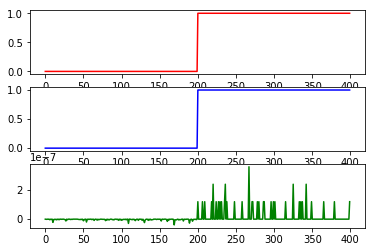

In [13]:
Y_pred = model.predict(X_test)

plt.subplot(3, 1, 1)
plt.plot(Y_test[:, 1], 'r')

plt.subplot(3, 1, 2)
plt.plot(Y_pred[:, 1], 'b')

plt.subplot(3, 1, 3)
plt.plot(Y_test[:, 1] - Y_pred[:, 1], 'g')

plt.show()

In [14]:
now = datetime.datetime.now()

# modelSaved = '{}-{}_{}_{}.h5'.format(folderNormal, folderFault, pretrainedModel, now.strftime('%m-%d-%H:%M:%S'))

modelSaved = '{}-{}_{}_{}.h5'.format(folderNormal, folderFault, pretrainedModel, now.strftime('%m-%d-%H-%M-%S'))
meanSaved = 'mean_{}.npy'.format(now.strftime('%m-%d-%H-%M-%S'))
stdSaved = 'std_{}.npy'.format(now.strftime('%m-%d-%H-%M-%S'))

inputStr = input('''Save Model as '{}'? (y/n)\n'''.format(modelSaved))

if (inputStr == 'y' or inputStr == 'Y'):  
    model.save(modelPath + '/{}'.format(modelSaved))
    np.save(modelPath + '/{}'.format(meanSaved), trainMean)
    np.save(modelPath + '/{}'.format(stdSaved), trainStd)

Save Model as '['P3N1']-['P3N5']_DenseNet201_11-16-18-00-13.h5'? (y/n)
y
